# Loki PredEx
This notebook demonstrates how to run *Loki PredEx* on the normal human heart dataset. It takes about 1 min to run this notebook on MacBook Pro.

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import os

import loki.predex
sc.settings.set_figure_params(dpi=80, facecolor="white")

In [111]:
import loki.utils
import loki.preprocess
import torch

data_dir = './data'
model_path = os.path.join(data_dir, 'checkpoint.pt')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'gpu' if loki.utils.is_gpu_available() else 'cpu'

We provide the image-ST similarity matrix generated from the OmiCLIP model.
The sample data and embeddings are stored in the directory `data/loki_predex/`, which can be donwloaded from [Google Drive link](https://drive.google.com/file/d/1aPK1nItsOEPxTihUAKMig-vLY-DMMIce/view?usp=sharing).

Here is a list of the files that are needed to run the ST gene expression prediction on the human heart dataset:
```
.
├── similarity_matrix
│   └── image_text_similarity.npy
├── training_data
│   ├── all_shared_genes.txt
│   ├── combined_expression_matrix.npy
│   ├── combined_obs.npy
│   └── train_df.csv
└── validation_data
    ├── HCAHeartST11702009.h5ad
    ├── top300_gene_list.npy
    └── val_df.csv                                   
```

# Training data 

In [95]:
# data_path = './data/loki_predex/' 
data_path = './loki_predex/' 

In [97]:
train_df = pd.read_csv(os.path.join(data_path, 'training_data', 'train_df.csv'), index_col=0)
# print(train_df.head())

# Load Validation Data - HEST 

In [2]:
import os

hest_path = "/work/bose_lab/tahsin/data/HEST"

# Expand user (~) in the path
# hest_path_expanded = os.path.expanduser(hest_path)
hest_path_expanded = hest_path

if os.path.isdir(hest_path_expanded):
    print(f"Directory exists: {hest_path_expanded}")
else:
    print(f"Directory does not exist: {hest_path_expanded}")

Directory exists: /work/bose_lab/tahsin/data/HEST


In [3]:
# from huggingface_hub import login


In [4]:
# from datasets import get_dataset_config_names, load_dataset

# print(get_dataset_config_names("MahmoodLab/hest"))

## Metadata loading/investigation

In [102]:
import datasets

meta_df = pd.read_csv(os.path.join(hest_path, "HEST_v1_1_0.csv"))

# Filter the dataframe to only include rows where 'organ' is 'Heart'
meta_df = meta_df[meta_df['organ'] == 'Heart']
print(meta_df.shape)
trained_meta = meta_df[meta_df['subseries'].isin(train_df['sample_name'].unique())] # The training set used by Loki
# Filter out the rows where 'id' is in train_df['sample_name']
# This is to ensure that we do not query the same samples that were used in training
meta_df = meta_df[~meta_df['subseries'].isin(train_df['sample_name'].unique())] # Validation set
ids_to_query = meta_df['id'].values

(70, 28)


Trying to determine if the id column corresponds to the file name in the metadata folder....

In [103]:
trained_meta.shape, meta_df.shape

((35, 28), (35, 28))

In [7]:
# test_path = os.path.join(hest_path, "metadata/SPA31.json")

# if os.path.exists(test_path):
#     print(f"File exists: {test_path}")
# else:   
#     print(f"File does not exist: {test_path}")

File exists: /work/bose_lab/tahsin/data/HEST/metadata/SPA31.json


In [91]:
meta_df

,dataset_title,id,image_filename,organ,disease_state,oncotree_code,species,patient,st_technology,data_publication_date,...,treatment_comment,pixel_size_um_embedded,pixel_size_um_estimated,magnification,fullres_px_width,fullres_px_height,tissue,disease_comment,subseries,hest_version_added
39,Spatially resolved multiomics of human cardiac...,MISC142,MISC142.tif,Heart,Healthy,NaN,Homo sapiens,,Visium,NaN,...,NaN,31.750063,0.454959,40x,18063,18100,right cardiac atrium,NaN,HCAHeartST10238251,v1_1_0
46,Spatially resolved multiomics of human cardiac...,MISC134,MISC134.tif,Heart,Healthy,NaN,Homo sapiens,,Visium,NaN,...,NaN,31.750063,0.441722,40x,17772,18231,atrioventricular node,NaN,HCAHeartST11290659,v1_1_0
51,Spatially resolved multiomics of human cardiac...,MISC129,MISC129.tif,Heart,Healthy,NaN,Homo sapiens,,Visium,NaN,...,NaN,31.750063,0.455373,40x,17243,17604,sinoatrial node,NaN,HCAHeartST11702009,v1_1_0
52,Spatially resolved multiomics of human cardiac...,MISC128,MISC128.tif,Heart,Healthy,NaN,Homo sapiens,,Visium,NaN,...,NaN,31.750063,0.455062,40x,17424,17709,sinoatrial node,NaN,HCAHeartST11702010,v1_1_0
57,Spatially resolved multiomics of human cardiac...,MISC123,MISC123.tif,Heart,Healthy,NaN,Homo sapiens,,Visium,NaN,...,NaN,63.500127,0.604839,20x,13207,13435,sinoatrial node,NaN,HCAHeartST13228105,v1_1_0
64,Spatially resolved multiomics of human cardiac...,MISC116,MISC116.tif,Heart,Healthy,NaN,Homo sapiens,,Visium,NaN,...,NaN,NaN,0.455580,40x,34560,19584,left cardiac atrium,NaN,HCAHeartST8795934,v1_1_0
143,Human Heart Data with Xenium Human Multi-Tissu...,TENX119,TENX119.tif,Heart,Healthy,NaN,Homo sapiens,NaN,Xenium,3/5/24,...,NaN,0.212500,0.273703,40x,24544,10645,Heart,NaN,NaN,v1_0_0
215,Human Heart,TENX15,TENX15.tif,Heart,Healthy,NaN,Homo sapiens,NaN,Visium,6/23/20,...,NaN,NaN,0.726844,20x,13332,13332,Heart,NaN,NaN,v1_0_0
339,A spatiotemporal organ-wide gene expression an...,SPA48,SPA48.tif,Heart,Healthy,NaN,Homo sapiens,NaN,Spatial Transcriptomics,16-Dec-19,...,NaN,NaN,0.848005,20x,9830,8602,Heart,4.5-5 Post Conception Week,ST_Sample_4.5-5PCW_1,v1_0_0
340,A spatiotemporal organ-wide gene expression an...,SPA47,SPA47.tif,Heart,Healthy,NaN,Homo sapiens,NaN,Spatial Transcriptomics,16-Dec-19,...,NaN,NaN,0.913181,20x,9830,8602,Heart,4.5-5 Post Conception Week,ST_Sample_4.5-5PCW_2,v1_0_0


*Ensure MISC105 is excluded from validation set, this is their selected training set*

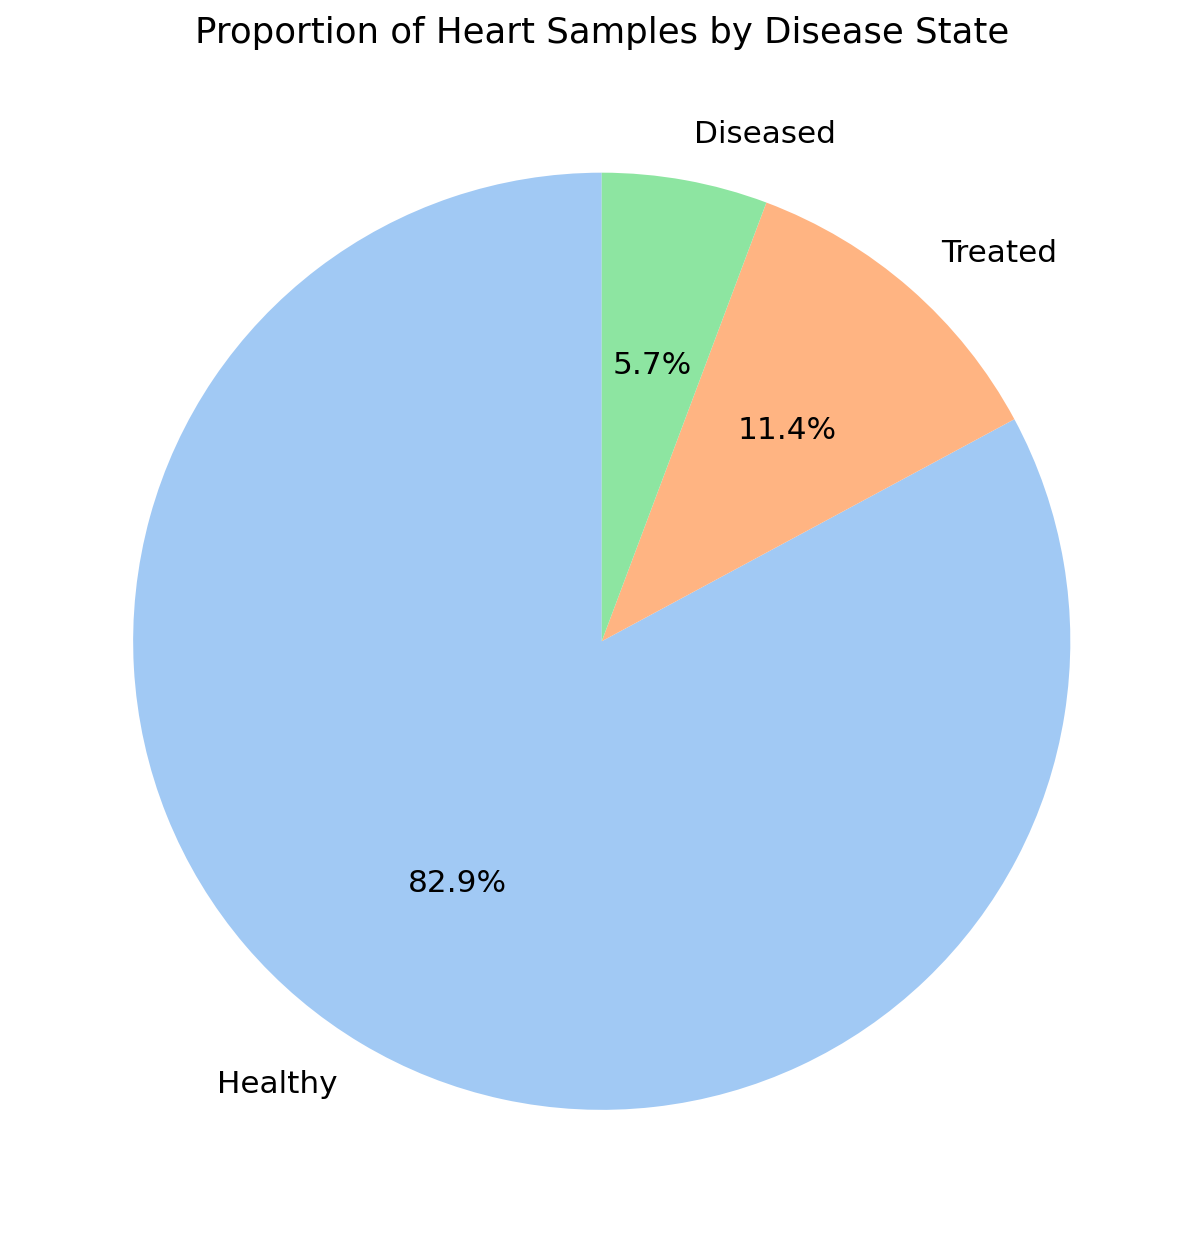

In [104]:
import seaborn as sns

import matplotlib.pyplot as plt

# Count the number of samples for each disease_state
disease_counts = meta_df['disease_state'].value_counts(dropna=False)

# Prepare data for seaborn
disease_df = disease_counts.reset_index()
disease_df.columns = ['disease_state', 'count']

# Create a color palette
colors = sns.color_palette('pastel')[0:len(disease_df)]

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    disease_df['count'],
    labels=disease_df['disease_state'],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 14}
)
plt.title('Proportion of Heart Samples by Disease State', fontsize=16)
plt.tight_layout()
plt.show()

In [105]:
import json

test_id = ids_to_query[0]  
# Load the metadata file for the first id in ids_to_query
metadata_file = os.path.join(hest_path, "metadata", test_id + ".json")
with open(metadata_file, 'r') as f:
    metadata = json.load(f)

print(json.dumps(metadata, indent=2))

{
  "pixel_size_um_embedded": 31.750063500127,
  "pixel_size_um_estimated": 0.45495886534339214,
  "spots_under_tissue": 1302,
  "spot_diameter": 55.0,
  "inter_spot_dist": 100.0,
  "fullres_px_width": 18063,
  "fullres_px_height": 18100,
  "dataset_title": "Spatially resolved multiomics of human cardiac niches",
  "subseries": "HCAHeartST10238251",
  "patient": NaN,
  "species": "Homo sapiens",
  "disease_comment": NaN,
  "disease_state": "Healthy",
  "oncotree_code": NaN,
  "tissue": "right cardiac atrium",
  "organ": "Heart",
  "preservation_method": "Fresh Frozen",
  "st_technology": "Visium",
  "data_publication_date": NaN,
  "license": "Creative Commons Attribution 4.0 International",
  "study_link": "https://www.nature.com/articles/s41586-023-06311-1#data-availability",
  "download_page_link1": "https://www.heartcellatlas.org/",
  "id": "MISC142",
  "treatment_comment": NaN
}


The metadata file has the same info as the csv.

## Genelist 

In [126]:
# Create dictionaries to convert between Ensembl gene IDs and HGNC symbols
conversion = pd.read_csv('../../../../tahsin/HEST/assets/gene_ids/hgnc_complete_set.txt', sep="\t").loc[:, ['ensembl_gene_id', 'symbol']]
convert_to_ens = conversion.set_index('symbol')['ensembl_gene_id'].to_dict()
convert_to_sym = conversion.set_index('ensembl_gene_id')['symbol'].to_dict()

/tmp/ipykernel_1674037/2255065410.py:1: DtypeWarning: Columns (32,34,38,40,50) have mixed types. Specify dtype option on import or set low_memory=False.
  conversion = pd.read_csv('../../../../tahsin/HEST/assets/gene_ids/hgnc_complete_set.txt', sep="\t").loc[:, ['ensembl_gene_id', 'symbol']]


(1302, 160)


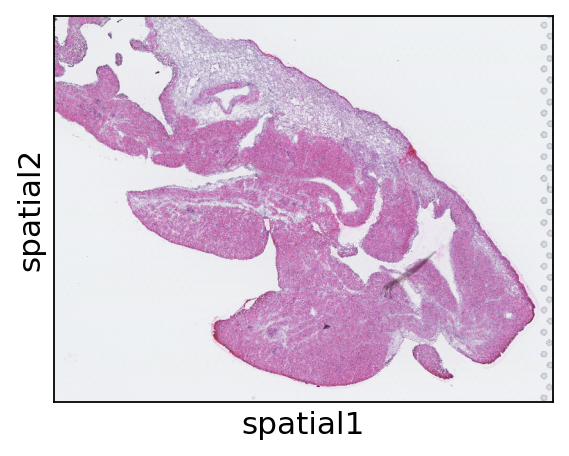

In [127]:
# Load the AnnData object for the test id
data_path = './loki_predex'
adata = sc.read_h5ad(os.path.join(hest_path, "st", test_id + ".h5ad"))

# top 300 genes in the validation data
genelist = list(np.load(os.path.join(data_path, 'validation_data', 'top300_gene_list.npy'),allow_pickle=True))
ensembl_genelist = [convert_to_ens[g] for g in genelist if g in convert_to_ens]

# Get the top 300 genes by mean expression in adata
mean_expression = np.asarray(adata.X.mean(axis=0)).flatten()
top300_idx = np.argsort(mean_expression)[-300:][::-1]
top300_genes = adata.var_names[top300_idx]

# Common genes between the top 300 genes in adata and the validation data
common_genes_ens = list(set(top300_genes).intersection(ensembl_genelist))
common_genes_sym = [convert_to_sym[gene] for gene in common_genes_ens if gene in convert_to_sym]

# Filter adata to only include the common genes
ad = adata[:, adata.var_names.isin(common_genes_ens)]
print(f"Number of spots in adata: {ad.shape[0]}, Number of genes: {ad.shape[1]}")

# The image:
sc.pl.spatial(adata, img_key="downscaled_fullres", show=True, spot_size=10)
# print(ad.obs.columns)
# print(ad.uns['spatial']['ST']['images'].keys())

## Get image for validation set

In [108]:
image_path = os.path.join(hest_path, "wsis", test_id + ".tif")

In [112]:
model, preprocess, tokenizer = loki.utils.load_model(model_path, device)

In [113]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None  # Disable DecompressionBombError

image_embeddings = loki.utils.encode_images(model, preprocess, [image_path], device)
image_embeddings.shape

torch.Size([1, 768])

In [114]:
from typing import List, Union
import torch.nn.functional as F


def encode_texts(
    model: torch.nn.Module,
    tokenizer: callable,
    texts: List[str],
    device: Union[str, torch.device]
) -> torch.Tensor:
    """
    Batch–encode a list of strings into L2‑normalized embeddings.
    Returns a tensor of shape (N, D).
    EDIT - Jamie had to fix because the text was not transferred to the correct device before encoding.
    """
    # Tokenizer returns a dict of tensors
    text_inputs = tokenizer(texts)
    if isinstance(text_inputs, dict):
        text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
    else:
        text_inputs = text_inputs.to(device)
    
    with torch.no_grad():
        feats = model.encode_text(text_inputs).to(device)             # (N, D)
    return F.normalize(feats, p=2, dim=-1)   

In [128]:
text_embeddings = encode_texts(model, tokenizer, common_genes_sym, 'cuda')
text_embeddings.shape

torch.Size([160, 768])

In [129]:
dot_similarity = image_embeddings @ text_embeddings.T

In [137]:
len(common_genes_sym)

160

In [130]:
print(dot_similarity)

tensor([[0.3914, 0.3936, 0.3877, 0.3661, 0.4006, 0.3705, 0.3804, 0.3861, 0.3808,
         0.3805, 0.3807, 0.3643, 0.3769, 0.3852, 0.3775, 0.3453, 0.3700, 0.3596,
         0.3399, 0.4058, 0.3823, 0.3986, 0.3663, 0.3601, 0.3525, 0.3959, 0.3965,
         0.3789, 0.3434, 0.3922, 0.3924, 0.3384, 0.3748, 0.3314, 0.3798, 0.3580,
         0.3940, 0.3559, 0.3835, 0.4024, 0.3765, 0.4128, 0.3524, 0.3500, 0.3722,
         0.3330, 0.3880, 0.3785, 0.3622, 0.3775, 0.3545, 0.3756, 0.3836, 0.3726,
         0.4055, 0.3712, 0.4010, 0.3635, 0.3818, 0.3541, 0.3544, 0.3635, 0.3673,
         0.4023, 0.4185, 0.3582, 0.3812, 0.3803, 0.3804, 0.3186, 0.3736, 0.3301,
         0.3831, 0.3823, 0.3688, 0.3846, 0.3827, 0.3768, 0.3200, 0.3671, 0.3399,
         0.3716, 0.3704, 0.3995, 0.3841, 0.3612, 0.3892, 0.3492, 0.3692, 0.3792,
         0.3957, 0.3723, 0.3484, 0.4078, 0.3786, 0.3293, 0.4026, 0.2979, 0.3582,
         0.3629, 0.3896, 0.3820, 0.3749, 0.3581, 0.3388, 0.3688, 0.3495, 0.3631,
         0.3625, 0.3832, 0.3

In [ ]:
image_text_similarity = np.load(os.path.join(data_path, 'similarity_matrix', 'image_text_similarity.npy'))
image_text_similarity.shape # Theoretical shape: [n_samples, n_genes], actual shape: [n_val_spots, n_train_spots]

(9453, 84755)

In [13]:
# First, validate with same organ (heart), same tissue prep (fresh frozen), and same disease state (disease_state = 'Healthy')
test1_df = meta_df[(meta_df['organ'] == 'Heart') & (meta_df['preservation_method'] == 'Fresh Frozen') & (meta_df['disease_state'] == 'Healthy')]

def test(id):
    validation_data = sc.read_h5ad(os.path.join(hest_path, "st", id + ".h5ad"))
    

# Training Data

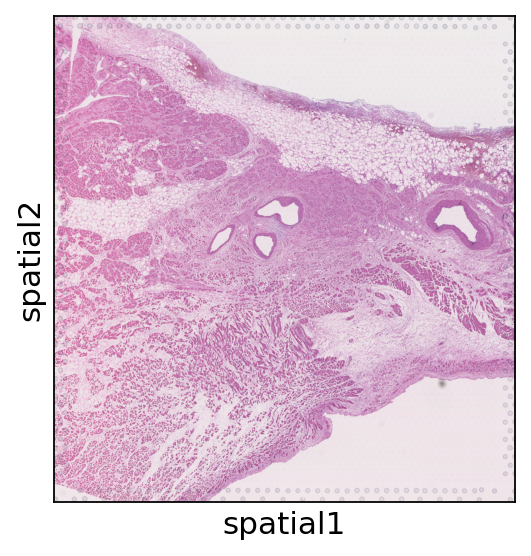

In [138]:
# Load the training data
adata1 = sc.read_h5ad(os.path.join(data_path, 'validation_data', 'HCAHeartST11702009.h5ad'))
genelist1 = list(np.load(os.path.join(data_path, 'validation_data', 'top300_gene_list.npy'),allow_pickle=True))
len(genelist1)
ad1 = adata1[:, adata1.var_names.isin(common_genes_sym)]
sc.pl.spatial(adata1, img_key="hires", show=False, spot_size=10)
del adata1
# Load the validation data
val_df = pd.read_csv(os.path.join(data_path, 'validation_data', 'val_df.csv'), index_col=0)
val_spots = val_df.index.tolist()
# print(val_spots)

## Loki PredEx by H&E image
Use Loki PredEx to predict ST gene expression from H&E image.

## Load and viz arrays

In [ ]:
# data_path = 'Summer/models/Loki/loki_predex/'

In [83]:
import numpy as np
import os
# array of combined expression matrix
combined_expression_array = np.load(os.path.join(data_path, 'training_data', 'combined_expression_matrix.npy'))
combined_expression_array.shape

(97060, 17922)

In [77]:
combined_expression_array.shape

(97060, 17922)

In [78]:
combined_obs_array = np.load(os.path.join(data_path,'training_data', 'combined_obs.npy'))
combined_obs_array[:10]

array(['HCAHeartST9383353_AAACAAGTATCTCCCA-1',
       'HCAHeartST9383353_AAACCCGAACGAAATC-1',
       'HCAHeartST9383353_AAACGAGACGGTTGAT-1',
       'HCAHeartST9383353_AAACTGCTGGCTCCAA-1',
       'HCAHeartST9383353_AAAGGCTACGGACCAT-1',
       'HCAHeartST9383353_AAAGGCTCTCGCGCCG-1',
       'HCAHeartST9383353_AAAGTGTGATTTATCT-1',
       'HCAHeartST9383353_AAAGTTGACTCCCGTA-1',
       'HCAHeartST9383353_AAATACCTATAAGCAT-1',
       'HCAHeartST9383353_AAATAGCTTAGACTTT-1'], dtype='<U37')

In [79]:
print(combined_obs_array.shape)

(97060,)


In [84]:
print(train_df['sample_name'].unique())

['HCAHeartST9383353' 'HCAHeartST13233999' 'HCAHeartST13233998'
 'HCAHeartST9383352' 'HCAHeartST10550732' 'HCAHeartST8795937'
 'HCAHeartST11350377' 'HCAHeartST8795940' 'HCAHeartST9383355'
 'HCAHeartST9383354' 'HCAHeartST11702008' 'HCAHeartST9383358'
 'HCAHeartST11290658' 'HCAHeartST8795936' 'HCAHeartST13228106'
 'HCAHeartST11290662' 'HCAHeartST11350375' 'HCAHeartST9341984'
 'HCAHeartST8795935' 'HCAHeartST12992074' 'HCAHeartST11290657'
 'HCAHeartST8795939' 'HCAHeartST8795938' 'HCAHeartST12992075'
 'HCAHeartST9383356' 'HCAHeartST12992072' 'HCAHeartST13233997'
 'HCAHeartST10238252' 'HCAHeartST9341982' 'HCAHeartST13228103'
 'HCAHeartST8795933' 'HCAHeartST9341983' 'HCAHeartST10238253'
 'HCAHeartST13233996' 'HCAHeartST10550730']


In [81]:
# Compare indices of train_df and val_df
train_indices_set = set(train_df.index)
val_indices_set = set(val_df.index)

common_indices = train_indices_set.intersection(val_indices_set)
only_in_train = train_indices_set - val_indices_set
only_in_val = val_indices_set - train_indices_set

print(f"Number of common indices: {len(common_indices)}")
print(f"Number of indices only in train_df: {len(only_in_train)}")
print(f"Number of indices only in val_df: {len(only_in_val)}")

Number of common indices: 0
Number of indices only in train_df: 84755
Number of indices only in val_df: 9453


In [143]:
print(train_df.index.tolist()[:10])  # Print first 10 indices for verification

['HCAHeartST9383353_AAACAAGTATCTCCCA-1', 'HCAHeartST9383353_AAACCCGAACGAAATC-1', 'HCAHeartST9383353_AAACGAGACGGTTGAT-1', 'HCAHeartST9383353_AAACTGCTGGCTCCAA-1', 'HCAHeartST9383353_AAAGGCTACGGACCAT-1', 'HCAHeartST9383353_AAAGGCTCTCGCGCCG-1', 'HCAHeartST9383353_AAAGTGTGATTTATCT-1', 'HCAHeartST9383353_AAAGTTGACTCCCGTA-1', 'HCAHeartST9383353_AAATACCTATAAGCAT-1', 'HCAHeartST9383353_AAATAGCTTAGACTTT-1']


## Get train_data

In [135]:
train_spots = train_df.index.tolist()
# with open(os.path.join(data_path, 'training_data', 'all_shared_genes.txt'), 'r') as f:
#     shared_genes = [line.strip() for line in f]
#     print("Shared genes:", shared_genes[:10])  # Print first 10 shared genes for verification
shared_genes = common_genes_sym

train_indices = np.isin(combined_obs_array, train_spots) # list of spot ids that are in the training set
val_indices = np.isin(combined_obs_array, val_spots)

train_data = combined_expression_array[train_indices, :] # Extract the training data based on the indices
val_data = combined_expression_array[val_indices, :]

# del combined_expression_array
# del train_df

In [136]:
# dot_similarity.to('cpu')
# dot_similarity = np.array(dot_similarity.cpu)
dot_similarity.cpu()
# train_data.to('cpu')
predicted_image_text_matrix = loki.predex.predict_st_gene_expr(dot_similarity.cpu(), train_data)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 84755 is different from 160)

In [28]:
image_text_similarity = np.load(os.path.join(data_path, 'similarity_matrix', 'image_text_similarity.npy'))
image_text_similarity[:10]

In [14]:
predicted_image_text_matrix = loki.predex.predict_st_gene_expr(image_text_similarity, train_data)
prediction = pd.DataFrame(predicted_image_text_matrix, index=val_df.index,columns=shared_genes)
predict_data = prediction[genelist]
predict_data = predict_data.loc[ad.obs_names]
predict_data

In [15]:
ad.layers['original'] = ad.X
ad.layers['loki'] = predict_data

In [16]:
ad.X=ad.layers['original'] 
sc.pl.spatial(ad, img_key="hires", color='MYH7', size=1.5, vmax='p90', vmin='p10', title='Ground Truth MYH Expression')

In [17]:
ad.X = ad.layers['loki']
sc.pl.spatial(ad, img_key="hires", color='MYH7', size=1.5, vmax='p90', vmin='p10', title='Loki Predicted MYH Expression')